<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### Load Data From CSV File


In [2]:
html = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'
df = pd.read_csv(html)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [5]:
df['loan_status'].value_counts(normalize=True)

PAIDOFF       0.751445
COLLECTION    0.248555
Name: loan_status, dtype: float64

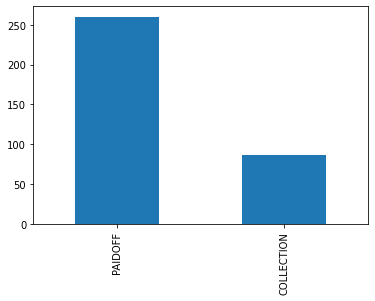

In [6]:
df['loan_status'].value_counts().plot(kind='bar')
plt.show()

260 people have paid off the loan on time while 86 have gone into collection


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

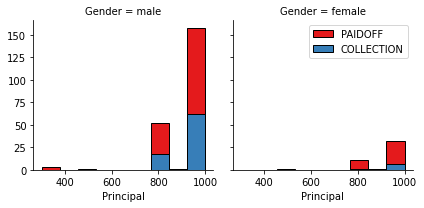

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

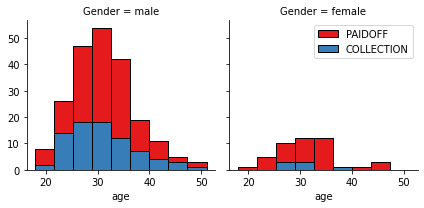

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


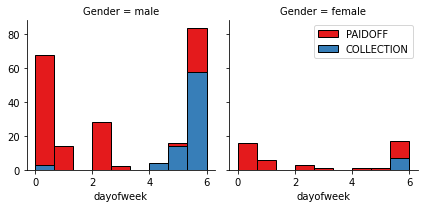

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Lets look at gender:


86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Split & Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


##### Train-Test-Split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


##### Standardization

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_test[:5])

[[ 0.56081126  0.9437816  -0.14485029 -0.40565621  0.85146932 -0.40565621
   1.10716144 -0.82639387]
 [-1.23900162 -0.9677917  -0.14485029 -0.40565621  0.85146932 -0.40565621
  -0.90321065  1.21007674]
 [ 0.56081126 -0.9677917   0.02383612 -0.40565621 -1.17444044 -0.40565621
   1.10716144 -0.82639387]
 [ 0.56081126  0.9437816  -1.15696879 -0.40565621 -1.17444044 -0.40565621
  -0.90321065  1.21007674]
 [ 0.56081126  0.9437816   0.52989537 -0.40565621 -1.17444044 -0.40565621
  -0.90321065  1.21007674]]


# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


##### Evaluation of the best Parameter "k"

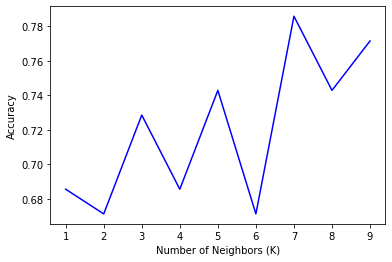

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))

for n in range(1,Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
plt.plot(range(1,Ks),mean_acc,'b')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.show()

##### Model Training with best Parameter "K"

In [22]:
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
yhat_neigh = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_neigh))

Train set Accuracy:  0.8115942028985508
Test set Accuracy:  0.7857142857142857


# Decision Tree


##### Evaluation of the best Parameter "max_depth"

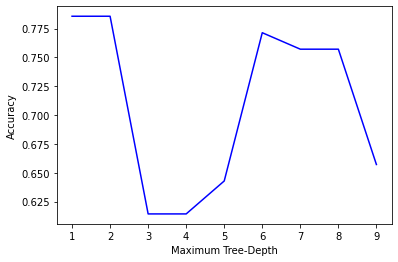

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
depth = 10
mean_acc = np.zeros((depth-1))

for n in range(1,depth):
     
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train, y_train)
    yhat=tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
plt.plot(range(1,depth),mean_acc,'b')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Tree-Depth')
plt.show()

##### Model Training with best Parameter "max_depth"

In [24]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_train, y_train)
yhat_tree = tree.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, tree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_tree))

Train set Accuracy:  0.7753623188405797
Test set Accuracy:  0.7714285714285715


# Support Vector Machine


##### Evaluation of the best Parameter "kernel"

[0. 0. 0. 0.]


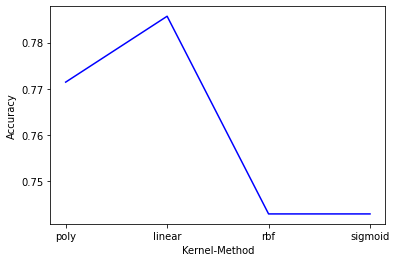

In [25]:
from sklearn import svm
from sklearn import metrics
kernel = ['poly', 'linear', 'rbf', 'sigmoid']
mean_acc = np.zeros((len(kernel)))
print(mean_acc)

for n in kernel:
    
    i = 0
    support = svm.SVC(kernel=n).fit(X_train, y_train)
    yhat=support.predict(X_test)
    mean_acc[kernel.index(n)] = metrics.accuracy_score(y_test, yhat)
    
plt.plot(kernel, mean_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('Kernel-Method')
plt.show()

##### Model Training with best Parameter "Kernel"

In [26]:
support = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat_svm = support.predict(X_test)
print('Train set Accuracy:', metrics.accuracy_score(y_train, support.predict(X_train)))
print('Test set Accuracy:', metrics.accuracy_score(y_test, yhat_svm))

Train set Accuracy: 0.7427536231884058
Test set Accuracy: 0.7857142857142857


# Logistic Regression


##### Evaluation of the best Parameters "C" and "solver"

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

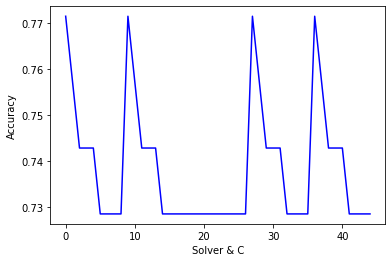

In [28]:
from itertools import product
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
prod = list(product(solvers, Cs))
prod_num = {prod.index(prod_item): prod_item for prod_item in prod}
mean_acc = np.zeros((len(prod)))

for n in prod:
    
    lr = LogisticRegression(C=n[1], solver=n[0]).fit(X_train, y_train)
    yhat=lr.predict(X_test)
    mean_acc[prod.index(n)] = metrics.accuracy_score(y_test, yhat)

plt.plot(list(prod_num.keys()), mean_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('Solver & C')
plt.show()

##### Model Training with best Parameter-Combination of "Solver" and "C"

In [29]:
print('Best Parameter-Combination:', prod_num[mean_acc.argmax()])
lr = LogisticRegression(C=0.1, solver='newton-cg').fit(X_train, y_train)
yhat_lr = lr.predict(X_test)
print('Train set Accuracy:', metrics.accuracy_score(y_train, lr.predict(X_train)))
print('Test set Accuracy:', metrics.accuracy_score(y_test, yhat_lr))

Best Parameter-Combination: ('newton-cg', 0.1)
Train set Accuracy: 0.7536231884057971
Test set Accuracy: 0.7714285714285715


# Model Evaluation using Test set


In [30]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation


In [31]:
html = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
test_df = pd.read_csv(html)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [32]:
test_df.shape

(54, 10)

##### Data Preparation

In [33]:
test_df['weekday'] = pd.to_datetime(test_df['effective_date']).dt.dayofweek
test_df['weekend'] = test_df['weekday'].apply(lambda x: 1 if (x>3)  else 0)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature['Gender'].replace(to_replace=['female', 'male'], value=[1, 0], inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


##### Transforming the Data

In [34]:
X_test = test_Feature
y_test = test_df['loan_status'].values
X_test = scaler.transform(X_test)

#### Evaluation of KNN

In [35]:
# Jaccard
print('Jaccard-Score:', metrics.jaccard_score(y_test, neigh.predict(X_test), pos_label='PAIDOFF'))

# F1-score
print('F1-Score:', metrics.f1_score(y_test, neigh.predict(X_test), pos_label='PAIDOFF'))

Jaccard-Score: 0.6981132075471698
F1-Score: 0.8222222222222222


#### Evaluation of Decision Tree

In [36]:
# Jaccard
print('Jaccard-Score:', metrics.jaccard_score(y_test, tree.predict(X_test), pos_label='PAIDOFF'))

# F1-score
print('F1-Score:', metrics.f1_score(y_test, tree.predict(X_test), pos_label='PAIDOFF'))

Jaccard-Score: 0.7115384615384616
F1-Score: 0.8314606741573034


#### Evaluation of SVM

In [37]:
# Jaccard
print('Jaccard-Score:', metrics.jaccard_score(y_test, support.predict(X_test), pos_label='PAIDOFF'))

# F1-score
print('F1-Score:', metrics.f1_score(y_test, support.predict(X_test), pos_label='PAIDOFF'))


Jaccard-Score: 0.7407407407407407
F1-Score: 0.851063829787234


#### Evaluation of Logistic Regression

In [38]:
# Jaccard
print('Jaccard-Score:', metrics.jaccard_score(y_test, lr.predict(X_test), pos_label='PAIDOFF'))

# F1-score
print('F1-Score:', metrics.f1_score(y_test, lr.predict(X_test), pos_label='PAIDOFF'))

#LogLoss
print('Log-Loss:', metrics.log_loss(y_test, lr.predict_proba(X_test)))

#Accuracy
print('Accuracy:', metrics.accuracy_score(y_test, lr.predict(X_test)))

Jaccard-Score: 0.7547169811320755
F1-Score: 0.8602150537634409
Log-Loss: 0.47282620532812886
Accuracy: 0.7592592592592593


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm              | Jaccard | F1-score | LogLoss |
|------------------------|---------|----------|---------|
| KNN                    | 0.70    | 0.82     | NA      |
| Decision Tree          | 0.71    | 0.83     | NA      |
| SVM                    | 0.74    | 0.85     | NA      |
| LogisticRegression     | 0.75    | 0.86     | 0.47    |
